# Read Me
The purpose of this code is to select the training dataset of JPG images and at the same time generate the log_data file that allows the identification of the selected galaxies.

# Set up

## Packages

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
# Import standard libraries for file and data handling
import os  # Operating system utilities (e.g., file paths)
import zipfile  # For extracting compressed .zip files
import requests  # To perform HTTP requests (e.g., downloading files)
import numpy as np  # Numerical operations and array handling
import pandas as pd  # Data manipulation and analysis
from io import BytesIO  # Handle in-memory byte streams (useful for downloading files)
import matplotlib.pyplot as plt  # Plotting and data visualization


## Funtions

In [ ]:
def class_simplification(subclass):
    """
    Simplifies a detailed subclass label into a main class label based on predefined mapping.

    Parameters:
    - subclass (str): The subclass label to simplify.

    Returns:
    - (str): The corresponding main class label if matched, otherwise returns the original input.
    """

    # Dictionary mapping prefixes of subclass labels to main class labels
    main_class = {
        "Ser": "Ser",
        "Seb": "Seb",
        "Sen": "Sen",
        "SB": "SB",
        "Sd": "Sd",
        "Sc": "Sc",
        "Sb": "Sb",
        "Sa": "Sa",
        "Er": "Er",
        "Ei": "Ei",
        "Ec": "Ec"
    }

    # Sort keys by length in descending order to match longer prefixes first
    sorted_keys = sorted(main_class.keys(), key=len, reverse=True)

    # Iterate over each key and check if it is a substring of the input subclass
    for key in sorted_keys:
        if key in subclass:
            return main_class[key]  # Return the simplified class

    return subclass  # Return original label if no match is found

def images_extraction(respuesta, log_data, dataset_type):
    """
    Extracts image files from a ZIP archive response and saves them into a dataset folder.

    Parameters:
    - respuesta (requests.Response): The HTTP response containing the ZIP file.
    - log_data (DataFrame): A DataFrame with an 'asset_id' column containing image identifiers.
    - dataset_type (str): Either 'Train' or 'Test', indicating the destination folder.

    Returns:
    - None
    """

    # Validate dataset_type value
    if dataset_type == 'Train' or dataset_type == 'Test':

        # Check if the ZIP file was downloaded successfully
        if respuesta.status_code == 200:

            # Open the ZIP file from the HTTP response content
            with zipfile.ZipFile(BytesIO(respuesta.content)) as img_zip:

                # Iterate through asset IDs and extract each corresponding image
                for f in log_data['asset_id']:
                    file_to_extract = f'images/{f}.jpg'
                    img_zip.extract(file_to_extract, os.path.join(root_jpgs, dataset_type))

                print(f'{dataset_type} images were downloaded')

        else:
            print('Error al descargar el archivo')

    else:
        print("Error: dataset_type is wrong\nTry 'Train' or 'Test'")

    return None

def histogram_class(log_data, dataset_type):
    """
    Plots and saves a bar chart showing the class distribution for a given dataset.

    Parameters:
    - log_data (DataFrame): Dataset containing a 'gz2_class' column with galaxy class labels.
    - dataset_type (str): Label to indicate the dataset being plotted ('Train' or 'Test').

    Returns:
    - None
    """

    # Count the frequency of each class label
    frecuencies = log_data['gz2_class'].value_counts()

    # Sort class labels alphabetically
    clases = sorted(frecuencies.index)

    # Reorder frequency series by sorted class names
    frecuencies = frecuencies.reindex(clases)

    # Plot bar chart
    plt.bar(frecuencies.index, frecuencies)
    plt.title(f'Class frequencies for {dataset_type} dataset')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.grid(axis='y')  # Add horizontal grid lines

    # Adjust layout and save the figure as PDF
    plt.tight_layout()
    plt.savefig(os.path.join(root_log_data, f'histogram_{dataset_type}.pdf'))

    # Show the plot
    plt.show()

    return None

## Directories

In [ ]:
root_log_data = '/content/drive/MyDrive/Practicas_Profesionales/Data/Log_data/'
root_jpgs = '/content/drive/MyDrive/Practicas_Profesionales/Data/JPGs'


# [Galaxy Zoo2 files ](https://data.galaxyzoo.org/#section-21)

In [ ]:
# Load the mapping of all observed galaxy objects and clean it
file_maping = pd.read_csv(os.path.join(root_log_data, 'gz2_filename_mapping.csv')).drop(columns='sample')

# Rename the 'objid' column to 'dr7objid' to match other datasets
file_maping.rename(columns={'objid': 'dr7objid'}, inplace=True)

# Load the classification data for galaxy images (Hart et al. 2016)
hart16 = pd.read_csv(os.path.join(root_log_data, 'gz2_hart16.csv'))


In [ ]:
# Merge the 'file_maping' and 'hart16' DataFrames using a common identifier
usefull_files = pd.merge(file_maping, hart16, on='dr7objid')


In [ ]:
# Selectively remove unnecessary columns from 'usefull_files' DataFrame

# Get a list of all current column names
columns_to_remove = list(usefull_files.keys())

# Retain only the columns we want to keep
columns_to_remove.remove('dr7objid')   # Unique identifier for the object
columns_to_remove.remove('gz2_class')  # Morphological class label
columns_to_remove.remove('asset_id')   # Image asset identifier

# Drop all other columns, keeping only the relevant ones
usefull_files.drop(columns=columns_to_remove, inplace=True)


# Log data files

In [ ]:
# Simplify the detailed class labels in the 'gz2_class' column
usefull_files['gz2_class'] = usefull_files['gz2_class'].apply(class_simplification)


# unzip images

In [ ]:
# Define the URL to download the Galaxy Zoo 2 image dataset (compressed in .zip format)
url = 'https://zenodo.org/records/3565489/files/images_gz2.zip'

# Send an HTTP GET request to download the ZIP file
respuesta = requests.get(url)


In [ ]:
# Check if the file was successfully downloaded
if respuesta.status_code == 200:
    # Open the ZIP file directly from the downloaded byte content
    with zipfile.ZipFile(BytesIO(respuesta.content)) as img_zip:
        print('Done')  # Indicate successful extraction setup
else:
    print('Error')  # Print error message if download failed


Done


In [ ]:
# Build a DataFrame with the asset IDs of all image files inside the ZIP archive

namelist = pd.DataFrame(
    [int(f[7:-4]) for f in img_zip.namelist() if f.startswith('images') and f.endswith('.jpg')],
    columns=['asset_id'])


In [ ]:
# Merge classification metadata with the list of available image files
files_to_use = pd.merge(usefull_files, namelist, on='asset_id')

# Shuffle the resulting DataFrame to randomize the sample order (reproducible with seed)
files_to_use = files_to_use.sample(frac=1, random_state=31)


In [ ]:
# Define the number of samples to include in each subset
dataset_size = 10_000

# Select the first 10,000 entries as the training dataset
log_data_train = files_to_use[:dataset_size]

# Select the next 10,000 entries as the test dataset
log_data_test = files_to_use[dataset_size:2*dataset_size]


In [ ]:
# Extract and save training images from the ZIP file response
images_extraction(respuesta, log_data_train, 'Train')

Train images were download


In [ ]:
# Extract and save testing images from the ZIP file response
images_extraction(respuesta,log_data_test,'Test')

Test images were download


In [ ]:
# Save the training dataset metadata to a CSV file
log_data_train.to_csv(os.path.join(root_log_data, 'log_data_train.csv'), index=False)

# Save the test dataset metadata to a CSV file
log_data_test.to_csv(os.path.join(root_log_data, 'log_data_test.csv'), index=False)

# Print the full path to the saved training metadata CSV file
print(os.path.join(root_log_data, 'log_data_train.csv'))

# Print the full path to the saved test metadata CSV file
print(os.path.join(root_log_data, 'log_data_test.csv'))


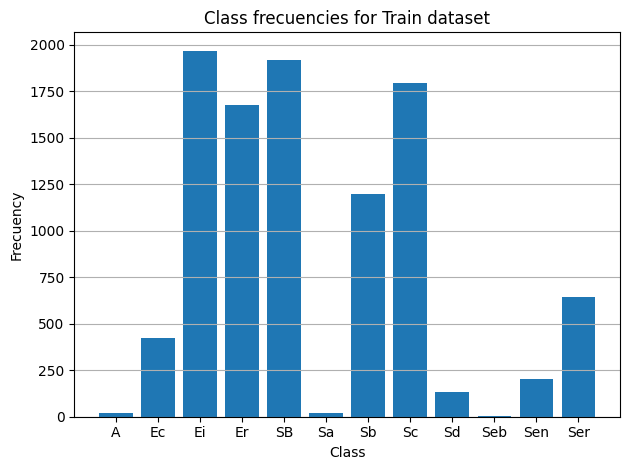

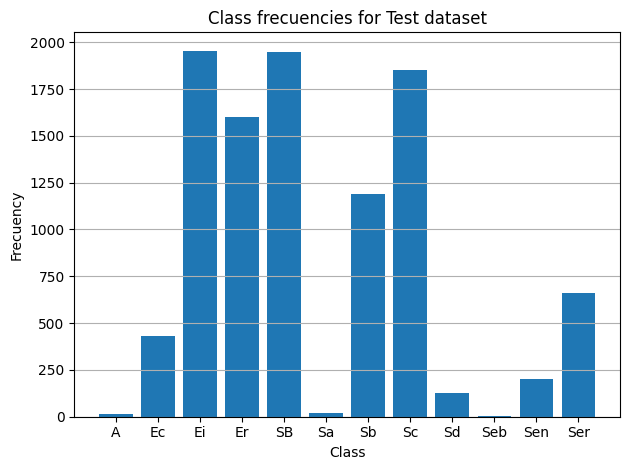

In [ ]:
# Plot and save the histogram of class frequencies for the training set
histogram_class(log_data_train, 'Train')

# Plot and save the histogram of class frequencies for the test set
histogram_class(log_data_test, 'Test')